In [27]:
import csv
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn import svm
from sklearn.metrics import confusion_matrix,precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import binarize 
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
# load data
# rows in X are subject major order, i.e. rows 0-9 are all samples from subject 0, rows 10-19 all samples from subject 1, etc.
# columns in X are in feature_type major order, i.e. columns 0-47 are alpha band power, eyes closed, electrodes 0-48
# feature identifiers for all columns in X are stored in feature_names.csv

X = np.loadtxt('data.csv', delimiter=',') 
y = np.loadtxt('labels.csv', delimiter=',')
with open('feature_names.csv') as f:
    csvreader = csv.reader(f, delimiter=',')
    feature_names = [row for row in csvreader][0]

In [3]:
# calculate Accuracy,Specificity,Sensitivity,MSE with confusion matrix
def calculate(pred, test):
    r2 = r2_score(test, pred) 
    mse = mean_squared_error(test, pred) 
    print('R2: ', r2) 
    print('MSE: ', mse)

    tn, fp, fn, tp = confusion_matrix(test, pred).ravel()
    print(confusion_matrix(test, pred))
    print(f"Accuracy: { (tp+tn)/(tp+fp+fn+tn)}")
    print(f"Specificity: {tp / (tp + fp)}")
    print(f"Sensitivity: {tp/(tp + fn)}")
    return [r2,mse,(tp+tn)/(tp+fp+fn+tn),tn/(tn + fp),tp/(tp + fn)]

In [22]:
# Original
clf=svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True) # classfier call svm
print(f"accuracy = {cross_val_score(clf,X,y,cv=10,scoring='accuracy').mean()}")
print(f"sensitivity = {cross_val_score(clf,X,y,cv=10,scoring='recall').mean()}")
print(f"Specificity = {cross_val_score(clf,X,y,cv=10,scoring='precision').mean()}")
print(f"MSE = {cross_val_score(clf,X,y,cv=10,scoring='neg_mean_squared_error').mean()}")



sc =  cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy').mean()    # Highest accuracy  


accuracy = 0.7666666666666666
sensitivity = 0.825
Specificity = 0.7073717948717949
MSE = -0.2333333333333333


In [32]:
# aggregation 
agg_feature = np.copy(X)
aggre_data = np.array([])
for i in range(9):
    aggre_data = np.hstack([aggre_data,np.mean(agg_feature[:,i*48:(i+1)*48],axis=1)])
aggre_data = aggre_data.reshape(180,9)


clf=svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True) # classfier call svm
train_X,test_X,train_y,test_y = train_test_split(aggre_data,y,test_size=0.2,random_state=0) # separate data to train data and test data
scores = cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy')  # Calculate the accuracy by cross vaildation 
print(f"accuracy = {cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy').mean()}")
print(f"sensitivity = {cross_val_score(clf,train_X,train_y,cv=10,scoring='recall').mean()}")
print(f"Specificity = {cross_val_score(clf,train_X,train_y,cv=10,scoring='precision').mean()}")
print(f"MSE = {cross_val_score(clf,train_X,train_y,cv=10,scoring='neg_mean_squared_error').mean()}")




# calculate(clf.predict(test_X),test_y)

accuracy = 0.8814285714285713
sensitivity = 0.7166666666666667
Specificity = 1.0
MSE = -0.11857142857142858


accuracy = 0.8890476190476191
sensitivity = 0.7333333333333334
Specificity = 1.0
MSE = -0.11095238095238094


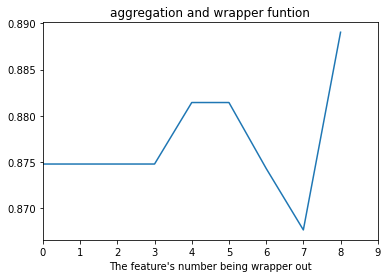

In [6]:
# Aggregation with wrapper function

agg_wrapper = [] # the number of the accuracy of the wrapped(one feature each time) X
clf=svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True) # classfier call svm
points = 0 # control the index 
agg_x_copy = np.copy(aggre_data) # Donot modified raw data call X
agg_sc = np.copy(sc)
# Iterate all feature one by one 
for i in range(9):
    f = np.hstack((agg_x_copy[:,:points],agg_x_copy[:,points+1:])) # elimate one feature 
    train_X,test_X,train_y,test_y = train_test_split(f,y,test_size=0.2,random_state=0) # separate data to train data and test data
    scores = cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy')  # Calculate the accuracy by cross vaildation 
    agg_wrapper.append(scores.mean())    #  Get the average accuracy 
    
    # Replace the highest accuracy and add the feature name which had been removed from the data
    if agg_sc <= scores.mean():
        agg_sc = scores.mean()
        agg_x_copy = np.delete(agg_x_copy,slice(points,points+1),1)
    else:
        points += 1
plt.title("aggregation and wrapper funtion")
plt.plot(agg_wrapper)
plt.xlim(0,9)
plt.xlabel("The feature's number being wrapper out")
clf.fit(train_X,train_y)
# print(calculate(clf.predict(test_X),test_y))
print(f"accuracy = {cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy').mean()}")
print(f"sensitivity = {cross_val_score(clf,train_X,train_y,cv=10,scoring='recall').mean()}")
print(f"Specificity = {cross_val_score(clf,train_X,train_y,cv=10,scoring='precision').mean()}")
print(f"MSE = {cross_val_score(clf,train_X,train_y,cv=10,scoring='neg_mean_squared_error').mean()}")






In [7]:
# Wrapper funtion with non-aggregation function

wrapper = [] # the number of the accuracy of the wrapped(one feature each time) X
clf=svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True) # classfier call svm
points = 0 # control the index 
x_copy = np.copy(X) # Donot modified raw data call X
removed = [] # stored the removed feature name 

# Iterate all feature one by one 
for i in range(9*48):
    f = np.hstack((x_copy[:,:points],x_copy[:,points+1:])) # elimate one feature 
    train_X,test_X,train_y,test_y = train_test_split(f,y,test_size=0.2,random_state=0) # separate data to train data and test data
    scores = cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy')  # Calculate the accuracy by cross vaildation 
    wrapper.append(scores.mean())    #  Get the average accuracy 
    
    # Replace the highest accuracy and add the feature name which had been removed from the data
    if sc <= scores.mean():
        sc = scores.mean()
        x_copy = np.delete(x_copy,slice(points,points+1),1)
        removed.append(feature_names[i])
    else:
        points += 1
    



# plt.plot(k_range,cv_scores)
# plt.xlabel('K')
# plt.ylabel('Accuracy')
# plt.show()
# cv_scores = np.array(cv_scores)
# best_knn = KNeighborsClassifier(n_neighbors=np.where(cv_scores==max(cv_scores))[0][0]+1)
# best_knn.fit(train_X,train_y)
# print(best_knn.score(test_X,test_y))
# calculate(best_knn.predict(test_X),test_y)



accuracy = 0.7523809523809524
sensitivity = 0.5833333333333334
Specificity = 0.7611904761904762
MSE = -0.24761904761904763


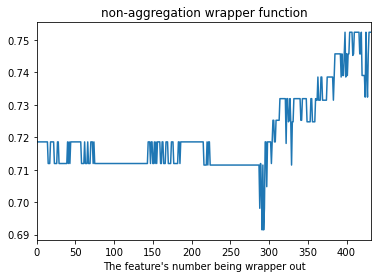

In [8]:
# plot the graph to show the prograss of accuracy 

plt.plot(wrapper)
plt.title("non-aggregation wrapper function")
plt.xlim(0,9*48)
plt.xlabel("The feature's number being wrapper out")
clf.fit(train_X,train_y)
# print(calculate(clf.predict(test_X),test_y))
print(f"accuracy = {cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy').mean()}")
print(f"sensitivity = {cross_val_score(clf,train_X,train_y,cv=10,scoring='recall').mean()}")
print(f"Specificity = {cross_val_score(clf,train_X,train_y,cv=10,scoring='precision').mean()}")
print(f"MSE = {cross_val_score(clf,train_X,train_y,cv=10,scoring='neg_mean_squared_error').mean()}")



<BarContainer object of 45 artists>

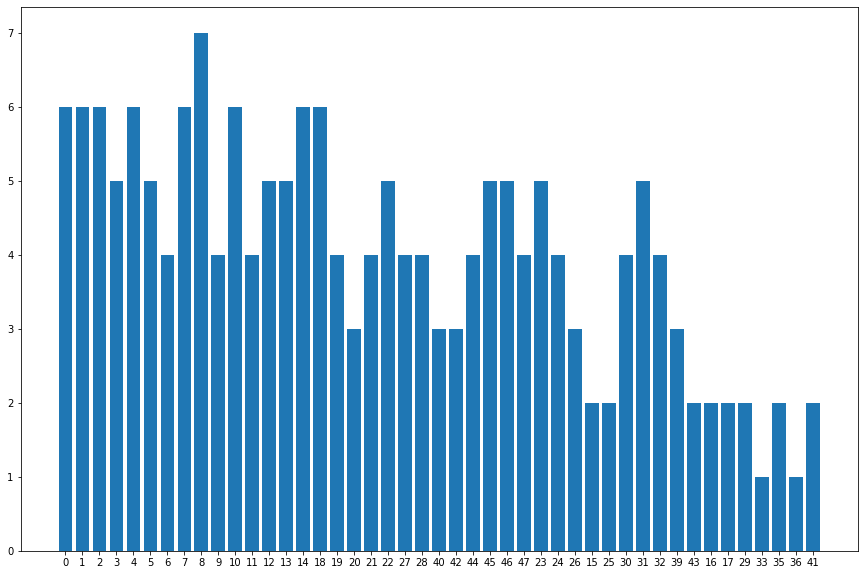

In [9]:
import re
from collections import Counter
ex_number = []
ex_feature = []
for i in removed:
    ex_number.append(re.search(r'\d?\d',i).group())
    ex_feature.append(re.search(r'[a-z]+',i).group())
    

result_num = Counter(ex_number)
result_feature = Counter(ex_feature)
plt.figure(figsize=(15,10))
plt.title("The number which has been elimnate from original data")
plt.bar(result_num.keys(),result_num.values())

<BarContainer object of 3 artists>

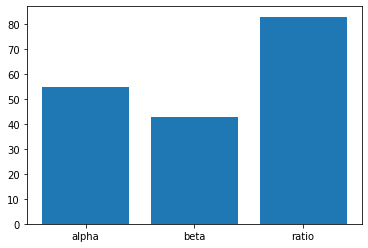

In [10]:
plt.bar(result_feature.keys(),result_feature.values())
plt.title("Poor performance feature")

In [11]:
# Aggregation with filter
agg_filter = [] # store the accuray for eeach time pick up the first # number after calucate by chi2
agg_filter_x = np.copy(aggre_data)  # copy again to not to affect the original one 
clf=svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True) # classfier call svm

for i in range(1,2):
    xx = SelectKBest(chi2, k=i).fit_transform(agg_filter_x,y)
    train_X,test_X,train_y,test_y = train_test_split(xx,y,test_size=0.2,random_state=0)
    scores = cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy')  
    
    if not agg_filter:
        agg_filter.append(scores.mean())
        continue
    if scores.mean() > max(agg_filter):
        agg_filter_x = xx
    agg_filter.append(scores.mean())
        
train_X,test_X,train_y,test_y = train_test_split(agg_filter_x,y,test_size=0.2,random_state=0)
# calculate(y_pred,test_y)
print(f"accuracy = {cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy').mean()}")
print(f"sensitivity = {cross_val_score(clf,train_X,train_y,cv=10,scoring='recall').mean()}")
print(f"Specificity = {cross_val_score(clf,train_X,train_y,cv=10,scoring='precision').mean()}")
print(f"MSE = {cross_val_score(clf,train_X,train_y,cv=10,scoring='neg_mean_squared_error').mean()}")





agg_result_filter = [cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy').mean(),
          cross_val_score(clf,train_X,train_y,cv=10,scoring='recall').mean(),
         cross_val_score(clf,train_X,train_y,cv=10,scoring='precision').mean()]

accuracy = 0.8814285714285713
sensitivity = 0.7166666666666667
Specificity = 1.0
MSE = -0.11857142857142858


In [12]:
# non-aggregation filiter  

filter_ = [] # store the accuray for eeach time pick up the first # number after calucate by chi2
filter_x = np.copy(X)  # copy again to not to affect the original one 
clf=svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True) # classfier call svm


for i in range(1,X.shape[1]):
    xx = SelectKBest(chi2, k=i).fit_transform(X,y)
    train_X,test_X,train_y,test_y = train_test_split(xx,y,test_size=0.2,random_state=0)
    scores = cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy')  
    
    if not filter_:
        filter_.append(scores.mean())
        continue
    if scores.mean() > max(filter_):
        filter_x = xx
    filter_.append(scores.mean())
        
train_X,test_X,train_y,test_y = train_test_split(filter_x,y,test_size=0.2,random_state=0)
# calculate(y_pred,test_y)
print(f"accuracy = {cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy').mean()}")
print(f"sensitivity = {cross_val_score(clf,train_X,train_y,cv=10,scoring='recall').mean()}")
print(f"Specificity = {cross_val_score(clf,train_X,train_y,cv=10,scoring='precision').mean()}")
print(f"MSE = {cross_val_score(clf,train_X,train_y,cv=10,scoring='neg_mean_squared_error').mean()}")


result_filter = [cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy').mean(),
          cross_val_score(clf,train_X,train_y,cv=10,scoring='recall').mean(),
         cross_val_score(clf,train_X,train_y,cv=10,scoring='precision').mean()]

accuracy = 0.758095238095238
sensitivity = 0.6833333333333333
Specificity = 0.729642857142857
MSE = -0.2419047619047619


In [13]:
# embedded with aggregation 
from sklearn.manifold import TSNE
agg_embedded = np.copy(aggre_data)
agg_embedded_num = [] # store the accuracy
agg_embedded_sep = [] # store the specificity
agg_embedded_sen = [] # store the sensitivity
agg_embedded_mse = [] # store the mse 
clf=svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True) # classfier call svm
for i in range(150):
    agg_embedded_x = TSNE(n_components=2,perplexity=i).fit_transform(agg_embedded)
    train_X,test_X,train_y,test_y = train_test_split(agg_embedded_x,y,test_size=0.2,random_state=0) # separate data to train data and test data
    clf.fit(train_X,train_y)
    y_pred = clf.predict(test_X)
    scores = cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy')  # Calculate the accuracy by cross vaildation 
    agg_embedded_num.append(cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy').mean()) #  Get the average accuracy
    agg_embedded_sen.append(cross_val_score(clf,train_X,train_y,cv=10,scoring='recall').mean())
    agg_embedded_mse.append(cross_val_score(clf,train_X,train_y,cv=10,scoring='neg_mean_squared_error').mean())
# highest accuracy sensitiviy s

print(f"accuracy = {np.max(agg_embedded_num)}")
print(f"Specificity = {np.max(agg_embedded_sen)}")
print(f"MSE = {np.max(agg_embedded_mse)}")




accuracy = 0.9657142857142856
Specificity = 0.95
MSE = -0.03428571428571429


In [14]:
# Embedding from sklearn: -tsne
# non-aggregation
from sklearn.manifold import TSNE
embedded = np.copy(X)
embedded_num = []
embedded_sen = []
embedded_mse = []

clf=svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True) # classfier call svm
for i in range(150):
    embedded_x = TSNE(n_components=2,perplexity=i).fit_transform(embedded)
    train_X,test_X,train_y,test_y = train_test_split(embedded_x,y,test_size=0.2,random_state=0) # separate data to train data and test data
    # Calculate the number by cross vaildation 
    embedded_num.append(cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy').mean()) #  Get the average accuracy
    embedded_sen.append(cross_val_score(clf,train_X,train_y,cv=10,scoring='recall').mean())
    embedded_mse.append(cross_val_score(clf,train_X,train_y,cv=10,scoring='neg_mean_squared_error').mean())

#  Get the highest accuracy 
print(f"accuracy = {np.max(embedded_num)}")
print(f"sensitivity = {np.max(embedded_sen)}")
print(f"MSE = {np.max(embedded_mse)}")

accuracy = 0.7852380952380952
sensitivity = 0.6666666666666667
MSE = -0.21476190476190476


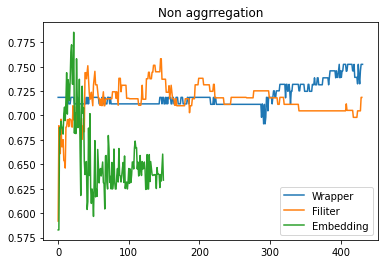

In [15]:
# Compare with the accuracy
plt.title("Non aggrregation")
plt.plot(wrapper,label="Wrapper")
plt.plot(filter_,label = "Filiter")
plt.plot(embedded_num,label = "Embedding")
plt.legend(loc=0)

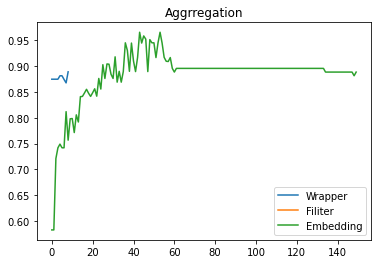

In [16]:
# Compare with the accuracy
plt.title("Aggrregation")
plt.plot(agg_wrapper,label="Wrapper")
plt.plot(agg_filter,label = "Filiter")
plt.plot(agg_embedded_num,label = "Embedding")
plt.legend(loc=0)

In [17]:
# plt.bar(["Wrapper","Filiter","Embedding"],[np.max(result),np.max(num),np.max(l_num)])
# plt.title("Best accuracy of each method")
# plt.ylabel("Accuracy")

In [18]:

# # Do the filiter after wrapper

# result = [] # store the accuray for eeach time pick up the first # number after calucate by chi2
# final_x = x_copy.copy()  # copy again to not to affect the original one 
# clf=svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True) # classfier call svm


# for i in range(1,x_copy.shape[1]):
#     xx = SelectKBest(chi2, k=i).fit_transform(x_copy,y)
#     train_X,test_X,train_y,test_y = train_test_split(xx,y,test_size=0.2,random_state=0)
#     scores = cross_val_score(clf,train_X,train_y,cv=10,scoring='accuracy')  
#     if not result:
#         result.append(scores.mean())
#     if scores.mean() > max(result):
#         final_x = xx
#     result.append(scores.mean())
        
# train_X,test_X,train_y,test_y = train_test_split(final_x,y,test_size=0.2,random_state=0)
# clf.fit(train_X,train_y)
# y_pred = clf.predict(test_X)
# calculate(y_pred,test_y)
# plt.plot(result)
# plt.xlabel("Doing wrapper after wrapper")
# plt.ylabel("Accuracy")

# """
# Become worse 
# Guess: it dont suit this data by chi2 
# """

In [19]:
# # Because wrapper plus filter is not in a good result 
# # Get the model back to the wapper function
# # wrapper = [train_X,train_y,test_X,test_y]
# clf=svm.SVC(kernel='rbf',C=1,gamma='auto',probability=True) # classfier call svm
# clf.fit(wrapper[0],wrapper[1])
# y_predict_prob = clf.predict_proba(wrapper[2]) #  show the probablity of the prediction 
# r = []
# m = []
# a = []
# sp = []
# se = []
# # Iteraite this for 0.1 to 0.9 add 0.1 each time 
# for i in range(1,10):
#     y_pred_class = binarize(y_predict_prob, threshold=i/10)[:,1] 
#     x = np.array(calculate(y_pred_class,wrapper[3]))
#     r.append(x[0])
#     m.append(x[1])
#     a.append(x[2])
#     sp.append(x[3])
#     se.append(x[4])
    

In [20]:
# print(f"Best threshold with accuracy(max) is {(np.where(a == max(a))[0][0]+1)/10}\n")
# print(f"Best threshold with mse(min) is {(np.where(m == min(m))[0][0]+1)/10}\n")

# print("For Best threshold")
# best = (np.where(a == max(a))[0][0]+1)/10
# y_pred_class = binarize(y_predict_prob, threshold=best)[:,1]
# calculate(y_pred_class,wrapper[3])

In [21]:
# plt.plot(np.arange(0.1,1,0.1),r)
# plt.plot((np.where(r == max(r))[0][0]+1)/10,max(r),'ro')
# plt.xlabel("R2")
# plt.show()

# plt.plot(np.arange(0.1,1,0.1),m)
# plt.plot((np.where(m == min(m))[0][0]+1)/10,min(m),'ro')
# plt.xlabel("MSE")
# plt.show()

# plt.plot(np.arange(0.1,1,0.1),a)
# plt.plot((np.where(a == max(a))[0][0]+1)/10,max(a),'ro')
# plt.xlabel("ACCUARCY")
# plt.show()

# plt.plot(np.arange(0.1,1,0.1),sp)
# plt.plot((np.where(sp == max(sp))[0][0]+1)/10,max(sp),'ro')
# plt.xlabel("Specificity")
# plt.show()

# plt.plot(np.arange(0.1,1,0.1),se)
# plt.plot((np.where(se == max(se))[0][0]+1)/10,max(se),'ro')
# plt.xlabel("Sensitivity")
# plt.show()


